# Clutch Up: Analyzing NFL Passing Tendencies in the Two-Minute Drill

## Exploratory Data Analysis

### Importing and Merging the Data

First, the data sets are loaded into the notebook environment using Python's `pandas` library to create three different DataFrames, `games`, `offense`, and `plays`, after reading the CSV files. The `offense` and `plays` DataFrames are then merged together on observations matching the `game_id` and `play_id` columns. This new data set contains 231,371 entries and 88 columns highlighting various aspects of player and play-level information. Therefore, `player_play_id` is the primary key representing the unique identifier for each player during each play in a given game. 

In [258]:
# Import appropriate libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sb

# Load the CSV data
games = pd.read_csv('games.csv')
offense = pd.read_csv('offense.csv')
plays = pd.read_csv('plays.csv')

#games.info()
#offense.info()
#plays.info()

# Merge `offense` and `plays` DataFrames first
df = pd.merge(offense, plays, on=["game_id", "play_id"])

df.info()

/var/folders/_p/_nvxtnln55d0tzzp53415t840000gn/T/ipykernel_76330/775207419.py:10: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  offense = pd.read_csv('offense.csv')
/var/folders/_p/_nvxtnln55d0tzzp53415t840000gn/T/ipykernel_76330/775207419.py:11: DtypeWarning: Columns (32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  plays = pd.read_csv('plays.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231371 entries, 0 to 231370
Data columns (total 88 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   game_id                    231371 non-null  object 
 1   play_id                    231371 non-null  object 
 2   team                       231371 non-null  object 
 3   player_id                  231371 non-null  object 
 4   player_play_id             231371 non-null  object 
 5   vs_player_play_id          17370 non-null   object 
 6   alignment                  231371 non-null  object 
 7   assignment                 231371 non-null  object 
 8   position                   231371 non-null  object 
 9   game_position              231371 non-null  object 
 10  ball_carrier               13883 non-null   object 
 11  passer                     21089 non-null   object 
 12  targeted_receiver          17370 non-null   object 
 13  passing_yards              11

### Cleaning the Data
Before conducting any analysis, it's important to check and fix any data issues, which can include duplicates, missing values, or incorrect data types. First, many of the variables are modified with the appropriate data type. Some integer columns with 0 or 1 values are converted to boolean. The boolean columns `off_is_touchdown` and `off_has_man_in_motion` have missing values, which are assumed to have False values. There are also 64 duplicated entries appearing in the primary key column, so these entries are removed.

In [259]:
# List of columns to convert from 0/1 to False/True
columns_to_convert = ['running_clock', 'no_play', 'no_huddle', 'play_action', 'catchable', 'pass_breakup']

# Convert 0 to False and 1 to True for the specified columns
for column in columns_to_convert:
    df[column] = df[column].replace({0: False, 1: True})

# Define columns having boolean values
boolean_columns = ['ball_carrier', 'passer', 'targeted_receiver', 'touchdown', 'interception', 'dropped_pass', 'pressure_allowed', 'sack_allowed', 'off_is_touchdown', 'off_has_man_in_motion']

# Fill missing values with False
df[boolean_columns] = df[boolean_columns].fillna(False)

# Convert columns to approproate data type
df = df.astype({
    'alignment': 'category',
    'assignment': 'category',
    'position': 'category',
    'game_position': 'category',
    'ball_carrier': 'bool',
    'passer': 'bool',
    'targeted_receiver': 'bool',
    'passing_yards': 'Int32',
    'receiving_yards': 'Int32',
    'rushing_yards': 'Int32',
    'yards_after_catch_x': 'Int32',
    'yards_after_contact_x': 'Int32',
    'touchdown': 'bool',
    'interception': 'bool',
    'tackles_avoided': 'Int32',
    'pass_route_group': 'category',
    'dropped_pass': 'bool',
    'pressure_allowed': 'bool',
    'sack_allowed': 'bool',
    'play_type': 'category',
    'play_result': 'category',
    'drive_play': 'Int32',
    'quarter': 'category',
    'running_clock': 'bool',
    'no_play': 'bool',
    'gain_loss': 'Int32',
    'off_yards': 'Int32',
    'off_rec_yards': 'Int32',
    'off_rush_yards': 'Int32',
    'yards_after_catch_y': 'Int32',
    'yards_after_contact_y': 'Int32',
    'penalty_yards': 'Int32',
    'off_is_touchdown': 'bool',
    'no_huddle': 'bool',
    'play_action': 'bool',
    'off_has_man_in_motion': 'bool',
    'offensive_formation': 'category',
    'offensive_formation_group': 'category',
    'off_qb_alignment': 'category',
    'off_rb_count': 'Int32',
    'off_te_count': 'Int32',
    'off_wr_count': 'Int32',
    'off_ol_count': 'Int32',
    'dropback_type': 'category',
    'dropback_depth': 'Int32',
    'pass_depth': 'Int32',
    'pass_direction': 'category',
    'catchable': 'bool',
    'primary_pass_concept': 'category',
    'left_route_concept': 'category',
    'right_route_concept': 'category',
    'def_dl_count': 'Int32',
    'def_lb_count': 'Int32',
    'def_db_count': 'Int32',
    'def_high_safety_count': 'Int32',
    'def_box_count': 'Int32',
    'def_pass_rusher_count': 'Int32',
    'pass_rush_result': 'category',
    'def_sacked_yards': 'Int32',
    'pass_breakup': 'bool'
})

# Count total number of duplicates in data set
df.duplicated().sum()

# Check PK for total duplicates
df["player_play_id"].duplicated().sum()

# Create new df without duplicates
df = df.drop_duplicates()

Next, each `play_id` should count exactly 11 values representing the 11 offensive players on the field. Since there is only one play in the entire data set without 11 men on the field, it won't hurt to remove this entry as well. About 6% of the remaining plays have been nullified by penalties, and these entries are also removed since the data does not contain enough information, like penalty type, to draw conclusions about their effect on the play's outcome. 

In [260]:
# Count number of `play_id` that do not equal 11
sum(df.play_id.value_counts() != 11)

# Filter the dataset to only include plays with 11 men on the field
play_id_counts = df.play_id.value_counts()
valid_play_id = play_id_counts[play_id_counts == 11].index
df = df[df["play_id"].isin(valid_play_id)]

# Count number of plays nullified by penalties
sum(df.no_play == 1)/11

# Filter out penalty plays
df = df[df["no_play"]==0]

# Check total plays
df.play_id.nunique()

19769

While `df` represents all passing plays without penalties throughout the season, a new data set is created to represent the following situation: passing plays in the fourth quarter with two minutes or less in which the offense is trailing by more than 3 but no more than 8 points.  Focusing on this specific scenario minimizes bias compared to analyzing all two-minute drill situations for a couple reasons. 

First, the analysis targets a set of plays that are more homogeneous in terms of offensive objectives and defensive expectations. This narrowed game context ensures that the offense's goal is unambiguous – they must score a touchdown to tie or win the game. Analyzing situations where a team might be playing for a field goal, running out the clock, or facing a large deficit increases the variability in the offense's intent which can introduce bias. Furthermore, defenses are more likely to play the pass and prevent big plays specifically, standardizing their approach and minimizing the variability in defensive play calling. 

Second, all teams in this scenario are operating under similar time constraints and urgency levels. This contrasts with broader two-minute drills where the urgency can vary widely based on the score differential. Teams down by a significant margin may behave differently than teams in a close game, introducing bias in the analysis of their play calling and execution. The stakes (i.e. the chance to tie or win the game) are comparable across all instances in this scenario, allowing for a more consistent analysis of late-game, high-pressure tendencies. This comparability is less certain in a broader set of two-minute drills where the importance of the game situation can vary. 

Ultimately, the homogeneity stemming from this scenario reduces the impact of various biases that can arise from differing game contexts. Hence, the `tm_needTD` DataFrame containing 363 plays (78 different drives) is created to reflect these conditions.

A successful drive for the offense in the defined scenario is one resulting in a touchdown – any other outcome will almost certainly result in a loss. Out of 78 total drives, there were 18 successes: 16 passing touchdowns, a seven-yard QB scramble, and a one-yard QB sneak (inferred by the "Jumbo" formation), equating to an approximate 23% success rate. Seventeen drives (~22%) ended with an interception, and the rest are assumed to end with a turnover on downs, fumble, or game clock expiration. 

In [261]:
# Convert `game_clock` to timedelta format
df["game_clock"] = pd.to_timedelta("00:" + df["game_clock"])

# Create variable score_differential (positive if offense is losing)
df["score_differential"] = df["def_score"] - df["off_score"]

# Create new dataset
tm_needTD = df.loc[
    (df.quarter == 4) & 
    (df.game_clock <= pd.Timedelta(minutes = 2)) & 
    (df.score_differential > 3) &
    (df.score_differential <= 8)]

# Create dataset not containing these specific plays for comparison purposes
non_tm_needTD = df.loc[~(
    (df.quarter == 4) & 
    (df.game_clock <= pd.Timedelta(minutes = 2)) & 
    (df.score_differential > 3) &
    (df.score_differential <= 8))]

print("Total plays: " + str(tm_needTD.play_id.nunique()) + "\n" + "Total drives: " + str(len(tm_needTD.groupby(['game_id', 'drive']))))

# Group by game_id and drive, then check if any play in a drive resulted in a touchdown
# Create a summary DataFrame indicating whether each drive had a touchdown
drive_summary = tm_needTD.groupby(["game_id", "drive"])[["touchdown", "interception"]].any().reset_index()

# Calculate the percentage of drives that result in a touchdown
percentage_touchdown_drives = ((drive_summary["touchdown"].sum() / len(drive_summary)) * 100).round(1)
#percentage_touchdown_drives

# Calculate the percentage of drives that result in an interception
percentage_int_drives = ((drive_summary["interception"].sum() / len(drive_summary)) * 100).round(1)
#percentage_int_drives

Total plays: 363
Total drives: 78


## Leaguewide Passing Characteristics of the Two-Minute Offense

### Passing Play Distributions
The basic strategy of the two-minute offense is to quickly and efficiently move the ball into scoring position. While there may be slight variations in personnel, alignment, and playcalling between teams, the two-minute script is generally predicated on field position, down, and clock management. These three factors should have an impact on where the ball is thrown and how aggressive or conservative the offense is. A new variable called `field_position_zone` is created that categorizes the existing `field_position` column into [four critical zones]("https://www.xsosfootball.com/executing-within-the-four-critical-zones/"): yellow, green, red, and goal line. The figure below shows the distribution of passing plays by `field_position_zone`, `down`, and `off_timeouts_remaining`. 

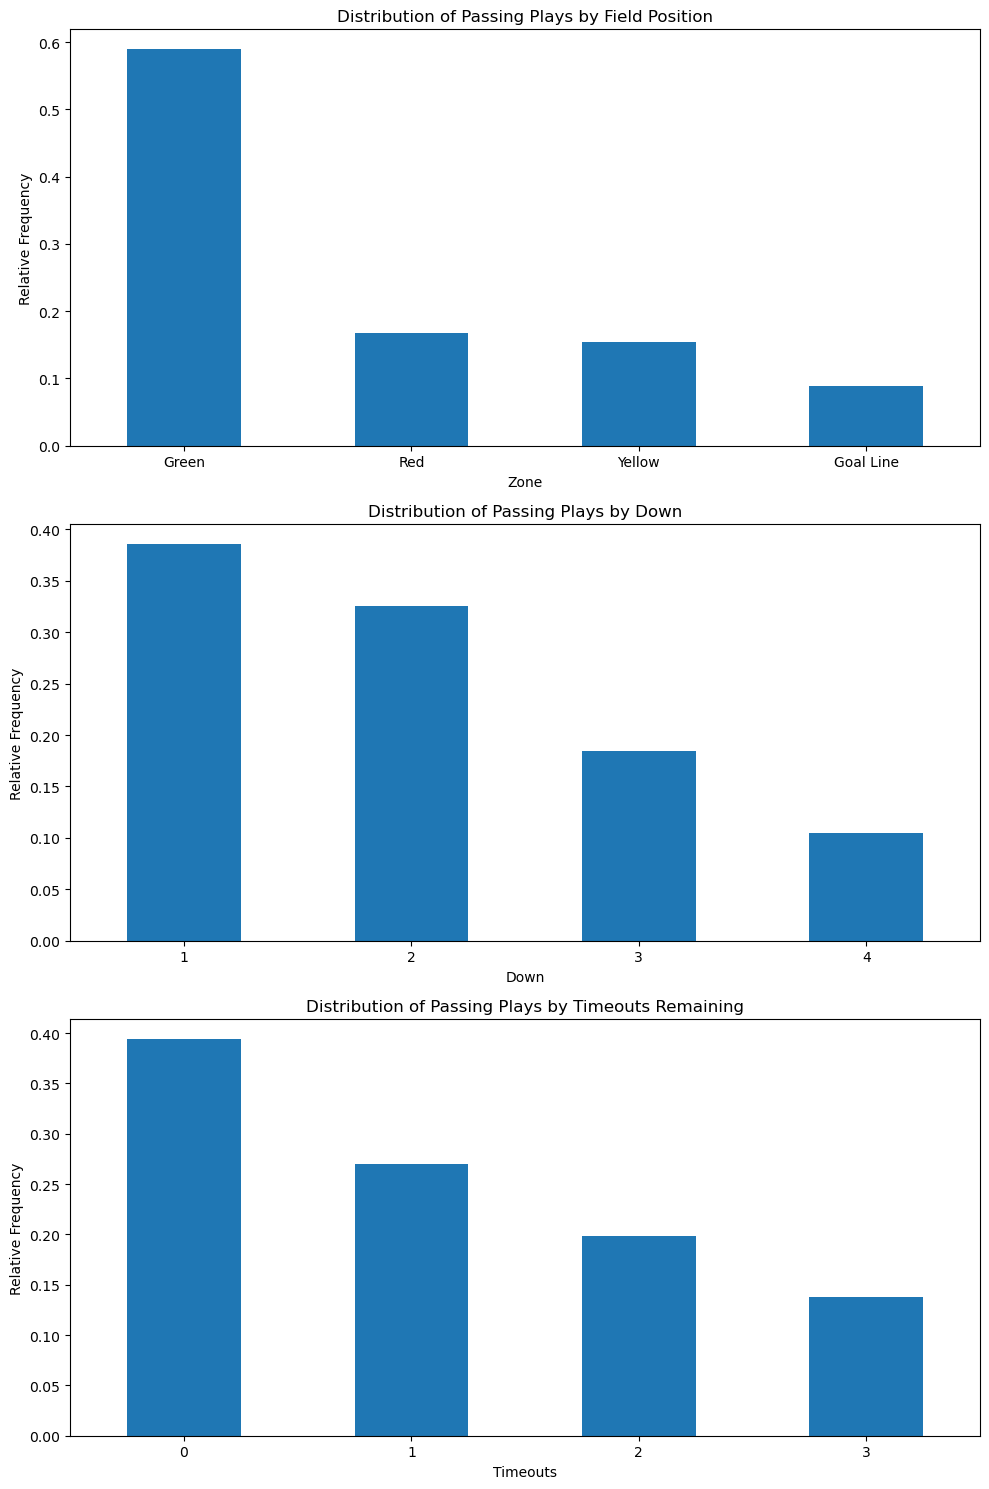

In [262]:
# Categorize field_position by zone
def categorize_field_position(field_position):
    if -25 <= field_position <= -1:
        return "Yellow"
    elif -26 >= field_position or 21 <= field_position:
        return "Green"
    elif 20 >= field_position >= 6:
        return "Red"
    elif 5 >= field_position >= 1:
        return "Goal Line"

# Create new "field_position_zone" column
tm_needTD = tm_needTD.copy()
tm_needTD["field_position_zone"] = tm_needTD["field_position"].apply(categorize_field_position)

# Plotting all three histograms in the same figure
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Distribution of Passing Plays by Field Position
tm_needTD["field_position_zone"].value_counts(normalize=True).plot(kind="bar", ax=axs[0])
axs[0].set_title("Distribution of Passing Plays by Field Position")
axs[0].set_xlabel("Zone")
axs[0].set_ylabel("Relative Frequency")
axs[0].tick_params(axis='x', rotation=360)

# Distribution of Passing Plays by Timeouts Remaining
tm_needTD["off_timeouts_remaining"].value_counts(normalize=True).plot(kind="bar", ax=axs[2])
axs[2].set_title("Distribution of Passing Plays by Timeouts Remaining")
axs[2].set_xlabel("Timeouts")
axs[2].set_ylabel("Relative Frequency")
axs[2].tick_params(axis='x', rotation=360)

# Distribution of Passing Plays by Down
tm_needTD["down"].value_counts(normalize=True).plot(kind="bar", ax=axs[1])
axs[1].set_title("Distribution of Passing Plays by Down")
axs[1].set_xlabel("Down")
axs[1].set_ylabel("Relative Frequency")
axs[1].tick_params(axis='x', rotation=360)

plt.tight_layout()
plt.show()

The majority of plays occur in the green zone, the largest chunk of the field between your own 26 yardline and the opponent's 21 yardline. This zone is generally where the offense runs its "bread and butter" plays and passing concepts to efficiently move the ball down the field. Just under 20% of plays occur in the yellow and red zones while about 10% of plays occur near the goal line. Given the late-game time constraint, it makes sense that the offense has 0 or 1 timeouts for the majority of these plays. Nearly 70% of these plays occur on first or second down – a possible reflection of the offense's aggressive play-calling in these pressure situations to move the chains as quickly as possible. Additionally, examining the average air yards per pass (labeled as `pass_depth`) in each zone could be an indication of just how aggressive offenses are based on field position. 

### Air Yards

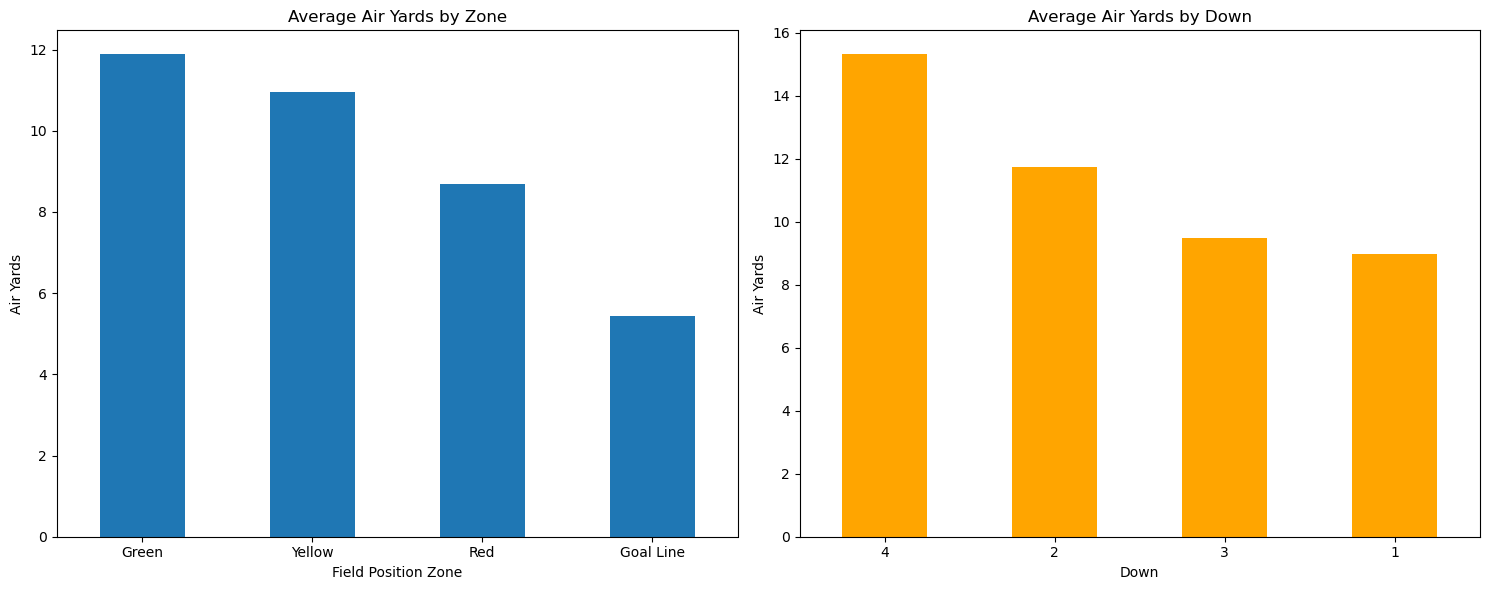

In [263]:
# Calculate average air yards
avg_pass_depth = tm_needTD.pass_depth.mean()

# Calculate the average pass_depth for each field_position_zone
avg_pass_depth_by_zone = tm_needTD.groupby('field_position_zone')['pass_depth'].mean()

# Calculate the average pass_depth by down
avg_pass_depth_by_down = tm_needTD.groupby('down')['pass_depth'].mean()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot the average pass depth by field position zone
avg_pass_depth_by_zone.sort_values(ascending=False).plot(kind='bar', ax=ax1)
ax1.set_title('Average Air Yards by Zone')
ax1.set_xlabel('Field Position Zone')
ax1.set_ylabel('Air Yards')
ax1.tick_params(axis='x', rotation = 0)

# Plot the average pass depth by down
avg_pass_depth_by_down.sort_values(ascending=False).plot(kind='bar', ax=ax2, color='orange')
ax2.set_title('Average Air Yards by Down')
ax2.set_xlabel('Down')
ax2.set_ylabel('Air Yards')
ax2.tick_params(axis='x', rotation=0)

# Adjust the layout
plt.tight_layout()
plt.show()

In [264]:
# Difference in average air yards in two-minute drill vs all other plays 
avg_pass_depth - non_tm_needTD.pass_depth.mean()

3.5911178712104537

Average air yards are roughly 4 yards higher in this specific two-minute scenario than the rest of the data, indicating that offenses tend to pass the ball more downfield. It's no surprise that average air yards are about three yards higher in the green and yellow zones compared to the red zone and goal line. Being further away from the end zone, offenses have more room to operate and take advantage of over-aggressive defenses, thus giving them an incentive to take downfield shots. Closer to the end zone, defensive backs are more likely to play closer to the line of scrimmage, and the risk associated with a turnover is higher the closer a team is to scoring, naturally leading to shorter pass attempts. 

On a similar note, offenses attempt shorter passes on first and third down, opting to make safer passes to keep the drive alive and/or set up for a more managable fourth-down scenario. Average air yards are the highest for fourth-down plays, about 15.3, which could be a byproduct of fourth-and-long desparation passes/hail marys, but are still a signal that offenses tend to attempt longer, riskier passes. 

From a defensive perspective, secondaries might adjust their coverages to account for these air-yard discrepancies depending on the field position and down. In situations where average air yards are higher, the secondary could play a softer zone or give a few extra yards of cushion in man coverage, and vice versa in situations where average air yards are lower. 

### Pass Direction

In addition to examining how far a pass is thrown, insights into the direction in which the pass is thrown could be advantageous for defenses. Football intuition would say that offenses look to throw the ball near the sideline more often during the two-minute drill to make it easier for receivers to get out of bounds and stop the clock. The data, however, shows that passes are thrown over the middle about 4% more often in two-minute situations when the offense needs a touchdown. While this may seem counterintuitive, there are other contextual factors shown in the figure below that could influence the pass direction. 

In [265]:
tm_needTD['pass_direction'][tm_needTD['pass_direction'] != 'X'].value_counts(normalize=True) * 100

pass_direction
M    53.465347
R    23.762376
L    22.772277
X     0.000000
Name: proportion, dtype: float64

In [266]:
non_tm_needTD['pass_direction'][non_tm_needTD['pass_direction'] != 'X'].value_counts(normalize=True) * 100

pass_direction
M    49.829076
R    26.048853
L    24.122071
X     0.000000
Name: proportion, dtype: float64

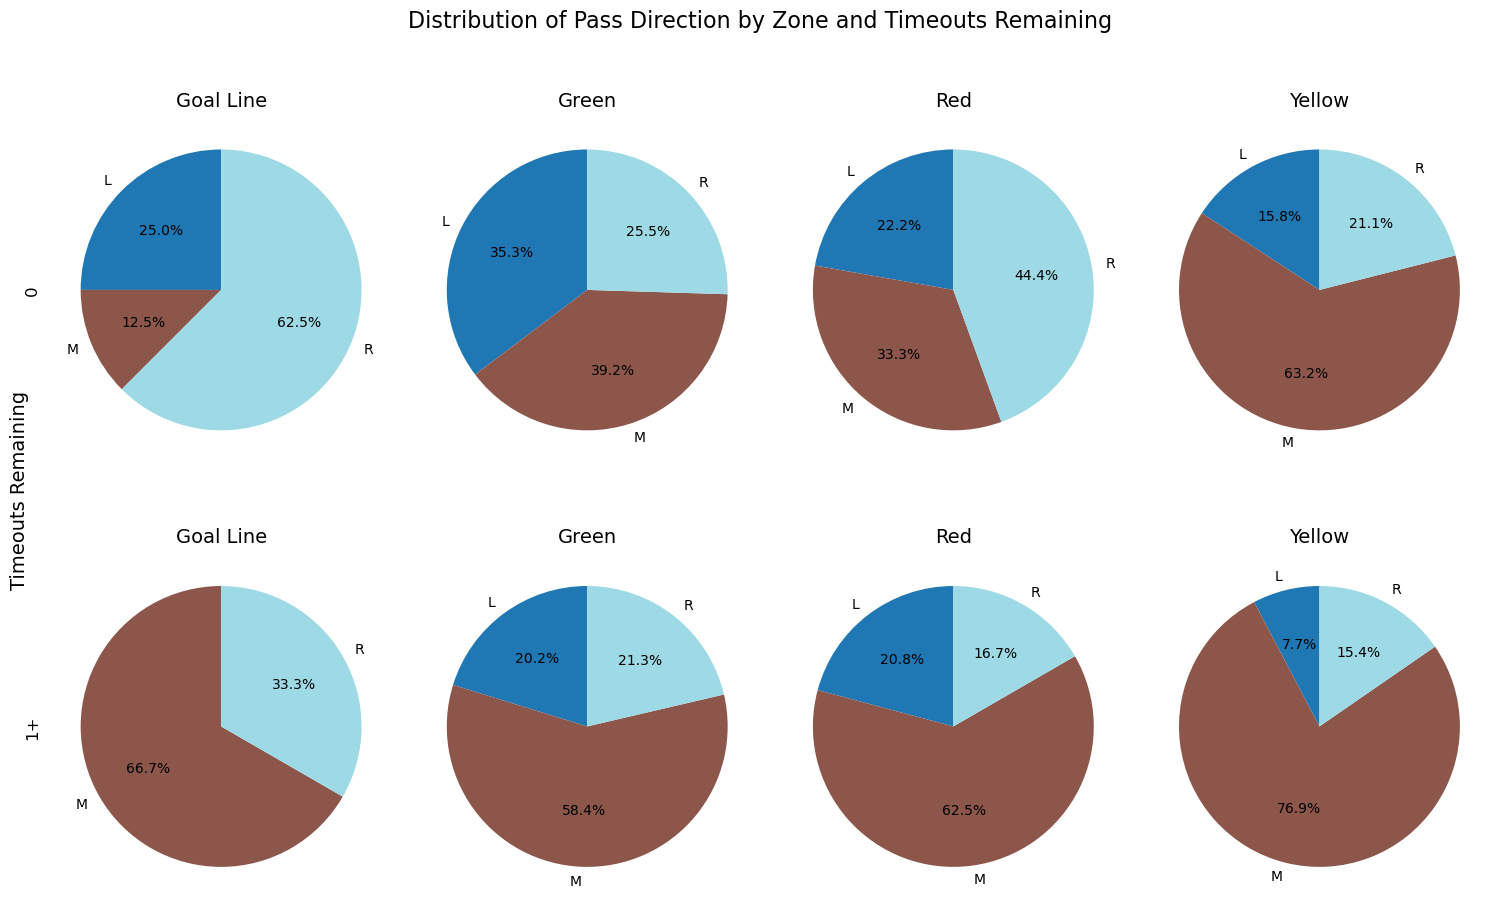

In [267]:
# Create a new column for grouped timeouts
tm_needTD["timeouts_group"] = tm_needTD["off_timeouts_remaining"].apply(lambda x: "1+" if x > 0 else "0")

# Filter and group as before, with the new timeouts_group
filtered_df = tm_needTD[(tm_needTD["down"].isin([1, 2])) & (tm_needTD["pass_direction"] != 'X')]
grouped_freq = filtered_df.groupby(["field_position_zone", "timeouts_group"])["pass_direction"].value_counts().unstack(fill_value=0)

# Determine unique zones and timeouts groups for layout
unique_zones = sorted(tm_needTD['field_position_zone'].unique())
unique_timeouts_groups = sorted(tm_needTD['timeouts_group'].unique(), key=lambda x: int(x) if x.isdigit() else float('inf'))

# Generate a consistent set of colors for pass directions
pass_directions = filtered_df['pass_direction'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(pass_directions)))
color_map = dict(zip(pass_directions, colors))

fig, axs = plt.subplots(nrows=len(unique_timeouts_groups), ncols=len(unique_zones), figsize=(15, 10))

# Main label for the rows
fig.text(0, 0.5, 'Timeouts Remaining', va='center', rotation='vertical', fontsize=14)

# If there's only one row or column, axs may not be a 2D array
if len(unique_timeouts_groups) == 1:
    axs = axs[None, :]
if len(unique_zones) == 1:
    axs = axs[:, None]

for i, timeouts_group in enumerate(unique_timeouts_groups):
    for j, zone in enumerate(unique_zones):
        ax = axs[i, j]
        data = grouped_freq.loc[(zone, timeouts_group)].drop(labels=[pass_direction for pass_direction, count in grouped_freq.loc[(zone, timeouts_group)].items() if count == 0], errors='ignore')
        if not data.empty:
            ax.pie(data, labels=data.index, autopct=lambda pct: f'{pct:.1f}%' if pct > 0 else '', startangle=90, colors=[color_map[label] for label in data.index])
            ax.set_title(f'{zone}', fontsize=14)
        else:
            ax.set_visible(False)  # Hide axes with no data
    # Label rows by timeouts remaining ("0" or "1+")
    row_label = "0" if timeouts_group == "0" else "1+"
    if len(unique_zones) > 1:
        axs[i, 0].set_ylabel(row_label, size=12)
    else:
        axs.set_ylabel(row_label, size=12)

plt.suptitle("Distribution of Pass Direction by Zone and Timeouts Remaining", fontsize = 16)
plt.tight_layout()
plt.show()

Clearly, teams are less afraid to throw the ball over the middle of the field when they have at least one timeout to burn. Interestingly, when in the yellow zone, offenses throw over the middle of the field over 60% of the time with 0 timeouts and over 75% of the time with 1 or more timeouts. This could be due to the fact that defenses might be anticipating shorter and safer routes near the boundary, like flats and quick outs, exposing the middle of the field for big yards-after-catch (YAC) opportunities. When offenses have one or more timeouts, defenses might even allow more throws over the middle to force the offense to use their timeouts. Therefore, defenses must scheme for the tradeoff between time and yards, i.e. either allowing either the receiver to step out of bounds or gain more yards over the middle. 

In [268]:
tm_needTD.groupby('pass_direction')['yards_after_catch_y'].mean()

pass_direction
L    2.432432
M    3.795918
R    2.129032
X        <NA>
Name: yards_after_catch_y, dtype: Float64

### Passing Concepts

After exploring passing depth and direction in two-minute drills, a more granular approach looking at the primary passing concepts can help the defense be better prepared for certain situations. Without considering for any of the previous contextual factors, the following five passing concepts account for over half of the plays: Verticals (37%), Slot Under (5%), Ohio (4%), China (4%), and Drive (4%). Verticals, to no surprise, has the highest average air yards at 16 yards. Medium-yard passing concepts like Slot Under, Ohio, and Drive have average air yards of 6.8, 8.9, and 7.8 yards, respectively. China has the shortest average air yards out of these five with 4.5 yards. 

In [269]:
tm_needTD.primary_pass_concept.value_counts(normalize=True).head()

primary_pass_concept
Vertical      0.371508
Slot Under    0.050279
Ohio          0.041899
China         0.041899
Drive         0.039106
Name: proportion, dtype: float64

In [270]:
tm_needTD.groupby('primary_pass_concept')['pass_depth'].mean()

primary_pass_concept
China                    4.466667
Curl Seam                9.714286
Curl Stop                9.642857
Dagger                     11.625
Dblmove                       0.0
Deep                    10.333333
Drive                    7.785714
Go Stop                  6.666667
Horizontal Stretch      12.714286
I/S Hilo                 5.846154
Ind Routes                   14.0
Indy                    15.142857
Lion/Dragon                   6.0
Mesh                     2.416667
Non QB Pass                  <NA>
O/S Hilo                 4.076923
Ohio                     8.866667
Out Seam                     16.5
Out Stop                      3.0
Pop                          17.5
Post Out                 6.333333
Quad Forms               6.666667
Sail                          8.5
Screen                   3.666667
Screen-HB                    -2.5
Screen-TE                    <NA>
Screen-WR                    0.75
Slot Under               6.833333
Smash                      

**Everything below this cell was not used for the analysis**

In [271]:
# Relative frequency of no huddle plays in non-two-minute situations
(league_non_two_minute.no_huddle.value_counts(normalize=True)*100).round(2)

no_huddle
False    91.5
True      8.5
Name: proportion, dtype: float64

In [272]:
# Relative frequency of no huddle plays in two-minute situations
(league_two_minute.no_huddle.value_counts(normalize=True)*100).round(2)

no_huddle
False    83.87
True     16.13
Name: proportion, dtype: float64

In [273]:
(league_two_minute.pass_direction.value_counts(normalize=True)*100).round(2)

pass_direction
M    40.70
R    21.41
L    20.51
X    17.38
Name: proportion, dtype: float64

In [274]:
(league_two_minute.loc[league_two_minute["pass_direction"] == "X", "play_result"].value_counts(normalize=True)*100).round(2)

play_result
SACK            35.8
THROWN AWAY     25.0
SCRAMBLE        19.8
BATTED PASS     10.2
HIT AS THREW     9.2
COMPLETE         0.0
INCOMPLETE       0.0
INTERCEPTION     0.0
LATERAL          0.0
NO PLAY          0.0
Name: proportion, dtype: float64